In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan ,isnull ,count ,when ,col ,split ,sum
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = SparkSession.builder.appName('credit').getOrCreate()

22/11/16 08:58:40 WARN Utils: Your hostname, ahmed008 resolves to a loopback address: 127.0.1.1; using 192.168.1.5 instead (on interface wlp2s0)
22/11/16 08:58:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/16 08:58:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
SOURCE_DATA = "../Source Data/onlinefraud.csv"
df = spark.read.csv(SOURCE_DATA,header=True,inferSchema=True)

In [4]:
# temp_df = df.createOrReplaceTempView('df')

# EDA

In [5]:
df.count()

6362620

In [6]:
# Add Duplicate Row
x = df.tail(1)
x = spark.createDataFrame(x)
df = df.union(x)

In [7]:
if df.count() > df.dropDuplicates().count():
    raise Exception("There Is Duplicate row")

Exception: There Is Duplicate row

In [8]:
print('Non Duplicate RowS Count : ',df.dropDuplicates().count())
print('Rows Count : ',df.count())

Non Duplicate RowS Count :  6362620


Rows Count :  6362621


In [5]:
df.head(3)

[Row(step=1, type='PAYMENT', amount=9839.64, nameOrig='C1231006815', oldbalanceOrg=170136.0, newbalanceOrig=160296.36, nameDest='M1979787155', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0),
 Row(step=1, type='PAYMENT', amount=1864.28, nameOrig='C1666544295', oldbalanceOrg=21249.0, newbalanceOrig=19384.72, nameDest='M2044282225', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0),
 Row(step=1, type='TRANSFER', amount=181.0, nameOrig='C1305486145', oldbalanceOrg=181.0, newbalanceOrig=0.0, nameDest='C553264065', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=1, isFlaggedFraud=0)]

In [6]:
spark.sql('SELECT * FROM df').show(truncate=False)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|1   |PAYMENT |9839.64  |C1231006815|170136.0     |160296.36     |M1979787155|0.0           |0.0           |0      |0             |
|1   |PAYMENT |1864.28  |C1666544295|21249.0      |19384.72      |M2044282225|0.0           |0.0           |0      |0             |
|1   |TRANSFER|181.0    |C1305486145|181.0        |0.0           |C553264065 |0.0           |0.0           |1      |0             |
|1   |CASH_OUT|181.0    |C840083671 |181.0        |0.0           |C38997010  |21182.0       |0.0           |1      |0             |
|1   |PAYMENT |11668.14 |C2048537720|41554.0      |29885.86      |M123070170

In [7]:
print('# Rows : ',df.count())

# Rows :  6362620


In [8]:
print('# Columns : ',len(df.columns))

# Columns :  11


In [40]:
# Get Nan
df.select( [count( \
                when(isnan(i) | isnull(i) | col(i).isNull(),i) \
                  ).alias(i) for i in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [12]:
print('Columns Name : ')
print(df.columns)

Columns Name : 
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [46]:
df.describe().show(truncate=False)

+-------+------------------+--------+------------------+-----------+-----------------+-----------------+-----------+------------------+------------------+--------------------+---------------------+
|summary|step              |type    |amount            |nameOrig   |oldbalanceOrg    |newbalanceOrig   |nameDest   |oldbalanceDest    |newbalanceDest    |isFraud             |isFlaggedFraud       |
+-------+------------------+--------+------------------+-----------+-----------------+-----------------+-----------+------------------+------------------+--------------------+---------------------+
|count  |6362620           |6362620 |6362620           |6362620    |6362620          |6362620          |6362620    |6362620           |6362620           |6362620             |6362620              |
|mean   |243.39724563151657|null    |179861.90354913412|null       |833883.1040744719|855113.6685785714|null       |1100701.6665196654|1224996.3982019408|0.001290820448180152|2.51468734577894E-6  |
|stddev |1

In [44]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [9]:
string_columns = [i[0] for i in df.dtypes if i[1].startswith('string')]
df.select(string_columns).show()

+--------+-----------+-----------+
|    type|   nameOrig|   nameDest|
+--------+-----------+-----------+
| PAYMENT|C1231006815|M1979787155|
| PAYMENT|C1666544295|M2044282225|
|TRANSFER|C1305486145| C553264065|
|CASH_OUT| C840083671|  C38997010|
| PAYMENT|C2048537720|M1230701703|
| PAYMENT|  C90045638| M573487274|
| PAYMENT| C154988899| M408069119|
| PAYMENT|C1912850431| M633326333|
| PAYMENT|C1265012928|M1176932104|
|   DEBIT| C712410124| C195600860|
|   DEBIT|C1900366749| C997608398|
| PAYMENT| C249177573|M2096539129|
| PAYMENT|C1648232591| M972865270|
| PAYMENT|C1716932897| M801569151|
| PAYMENT|C1026483832|M1635378213|
|CASH_OUT| C905080434| C476402209|
| PAYMENT| C761750706|M1731217984|
| PAYMENT|C1237762639|M1877062907|
| PAYMENT|C2033524545| M473053293|
|TRANSFER|C1670993182|C1100439041|
+--------+-----------+-----------+
only showing top 20 rows



In [4]:
df = df.withColumn('nameDest',split('nameDest','')[0])
df = df.withColumn('nameOrig',split('nameOrig','')[0])

In [50]:
df.show()

+----+--------+---------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|    type|   amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|       C|     170136.0|     160296.36|       M|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|       C|      21249.0|      19384.72|       M|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|       C|        181.0|           0.0|       C|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0|       C|        181.0|           0.0|       C|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|       C|      41554.0|      29885.86|       M|           0.0|           0.0|      0|        

In [12]:
# df_plot = df.toPandas()
# sns.histplot(df_plot)

Exception in thread "refresh progress" java.lang.OutOfMemoryError: Java heap space


Py4JJavaError: An error occurred while calling o48.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


In [59]:
# df.select('nameDest').distinct().show()

+--------+
|nameDest|
+--------+
|       M|
|       C|
+--------+



In [13]:
df.show()

+----+--------+---------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|    type|   amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|       C|     170136.0|     160296.36|       M|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|       C|      21249.0|      19384.72|       M|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|       C|        181.0|           0.0|       C|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0|       C|        181.0|           0.0|       C|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|       C|      41554.0|      29885.86|       M|           0.0|           0.0|      0|        

In [18]:
df.groupBy('nameDest').count().show()

+--------+-------+
|nameDest|  count|
+--------+-------+
|       M|2151495|
|       C|4211125|
+--------+-------+



(array([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 BarContainer objects>)

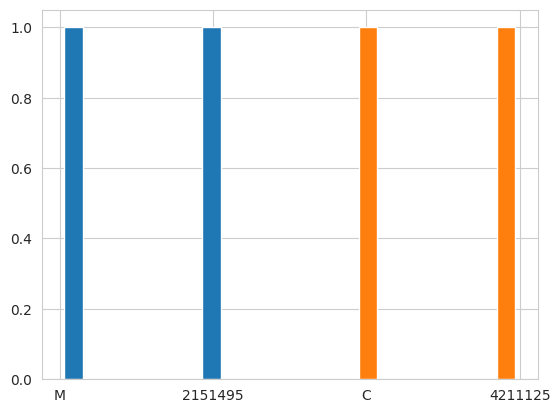

In [21]:
plt.hist(df.groupBy('nameDest').count().collect())

In [32]:
pdf = df.select('nameDest').toPandas()

In [5]:
df_sample = df.sample(fraction=0.10)
df_sample.show()

+----+--------+---------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|    type|   amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|       C|     170136.0|     160296.36|       M|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|       C|      21249.0|      19384.72|       M|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|       C|        181.0|           0.0|       C|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0|       C|        181.0|           0.0|       C|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|       C|      41554.0|      29885.86|       M|           0.0|           0.0|      0|        

In [ ]:
sns.histplot(df_sample.select('amount').collect())

<AxesSubplot: ylabel='Count'>

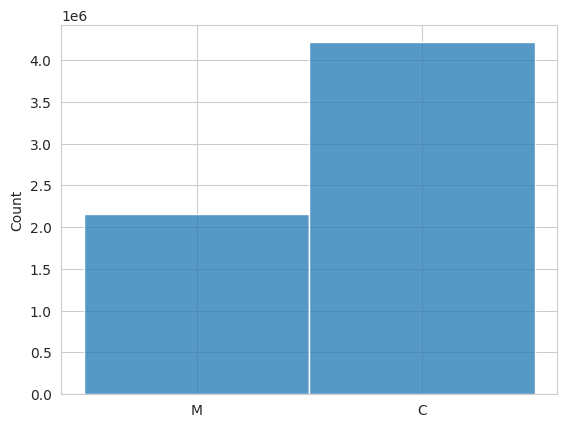

In [10]:
sns.histplot(df.rdd.map(lambda x :x.nameDest).collect())
plt.show()

<AxesSubplot: ylabel='Count'>

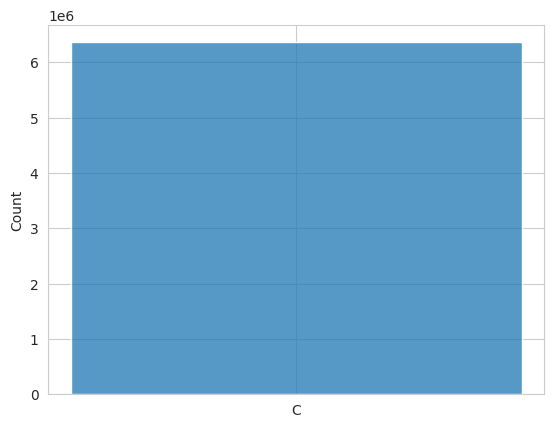

In [11]:
sns.histplot(df.rdd.map(lambda x :x.nameOrig).collect())